In [82]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated
from langchain_core.tools import tool
from IPython.display import Image, display
from langchain_community.tools import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
import os
load_dotenv()

True

In [8]:
tavily = TavilySearchResults(max_results=2)

In [81]:
class State(MessagesState):
    question: str
    messages: Annotated[list, add_messages]
    answer: str

In [36]:
def agent_tavily(state: State):
    print("----------agent tavily----------")
    messages = tavily.invoke(state["question"])
    
    state["messages"] = [f"source url: {c['url']} \n\n content: {c['content']}" for c in messages]
    return {"messages": state["messages"]}

In [67]:
def agent_wikipedia(state: State):
    print("----------wikipedia----------")
    messages = WikipediaLoader(query=state["question"], load_max_docs=1).load()
    state["messages"] = [f"content: {c}" for c in messages]
    return {"messages": state["messages"]}

In [86]:
def agent_llm(state: State):
    print("----------llm----------")
    model = ChatGoogleGenerativeAI(model = 'gemini-1.5-pro', api_key=os.environ["GEMINI_API_KEY"])
    
    question = state["question"]
    content = state["messages"]
    template = '''Question is {question} and answer me using this content - {content}'''
    all_content = template.format(question=question, content=content)
    answer = model.invoke([SystemMessage(content=all_content)] + [HumanMessage(content="Kindly answer the above in short in 5 lines")])
    return {"answer": answer}

In [94]:
builder = StateGraph(State)

In [ ]:
builder.add_node("tavily_agent", agent_tavily)
builder.add_node("wikipedia", agent_wikipedia)
builder.add_node("llm", agent_llm)

In [ ]:
builder.add_edge(START, "tavily_agent")
builder.add_edge(START, "wikipedia")
builder.add_edge(["tavily_agent", "wikipedia"], "llm")
builder.add_edge("llm", END)

In [97]:
graph = builder.compile()

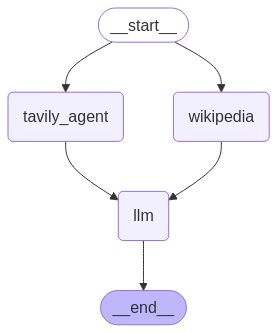

In [98]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
events = graph.invoke({"question": "what is an newton laws of motion"})

In [ ]:
print(events["answer"].content)